In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

# Метод оценки удачи в "Blood Bowl"
"Blood Bowl" как игра содержит в себе значительный элемент удачи, так что вопрос об измерении этой удачи встаёт весьма часто. В этой работе я пытаюсь разработать методику оценки удачи тренеров, опирающуюся на анализ результатов их бросков кубов.

## Входные данные для анализа
"Blood Bowl" - игра, где приходится кидать много кубов. В течение матча каждый тренер делает более сотни отдельных независимых бросков с разнообразными шансами успеха, провала и нейтрального исхода. Для начала анализа мы должны собрать все броски кубов для обоих тренеров: их шансы, результаты и количества. Это можно делать вручную; автоматизация процесса возможна, но лежит за пределами моей компетенции.

В результате мы получим для каждого тренера список отдельных бросков кубов вида [[chance_1, weight_1], [chance_2, weight_2], ... [chance_n, weight_n]], где chance - вероятность отдельного броска, weight - вес: был ли результат положительным (1), нейтральным (0) или отрицательным (-1).

Сумма всех возможных весов для каждого отдельного броска должна быть 0, т.е. у вас не может быть броска без положительного или отрицательного исхода (если вы делаете такие броски - не включайте их в список, они всё равно не влияют на вашу удачу).

Сумма всех возможных вероятностей для каждого отдельного броска должна быть 1, по определению вероятности.

## Рабочая гипотеза
Для каждого броска добавим новую метрику "удача", $luck = \frac{w\,e\,i\,g\,h\,t}{c\,h\,a\,n\,c\,e}$  
У неё есть несколько полезных свойств:
<ul>
    <li>знак, показывающий, был ли результат положительным или отрицательным;</li>
    <li>её величина по модулю тем больше, чем маловероятнее был бросок;</li>
    <li>ожидаемая суммарная удача для "справедливых" бросков кубов равна 0.</li>
</ul>
Докажем последнее утверждение. Представьте, что вы кидаете кубы n раз с шансом положительного исхода p, шансом отрицательного исхода q, шансом нейтрального исхода (1-p-q). Тогда со "справедливыми" кубами вы ожидаете получить положительный исход np раз, нейтральный исход n(1-p-q) раз и отрицательный nq раз. Ваша суммарная удача будет $\frac{1}{p}np+\frac{0}{1-p-q}n(1-p-q)+\frac{-1}{q}nq = n - n = 0$  
  
Такой же (при "справедливом" распределении удачи) должна быть суммарная удача за весь матч (далее "cumulative luck", CL). Если вы получили больше положительных исходов, чем ожидалось, ваше CL будет больше 0. Если больше отрицательных - меньше 0.

## Сравнение удачи
Для каждого тренера у нас есть список удач всех его бросков вида [[luck_1], [luck_2], ... [luck_n]]. Рассчитайте суммарную удачу тренера за весь матч как сумму всех удач его бросков 
$CL = \sum_{i=1}^n luck_i$  

Вы получите 2 числа (вероятно, не равных 0 и друг другу). Давайте попробуем оценить статистическую значимость различий между ними.  

Я предлагаю принять за нулевую гипотезу равенство настоящих CL тренеров, а затем оценить её p-value, сравнивая доверительные интервалы для наблюдаемых CL тренеров (используя [статью](https://www.researchgate.net/publication/7994369_Inference_by_Eye_Confidence_Intervals_and_How_to_Read_Pictures_of_Data)), построенные методом бутстрапа.  

Теперь мы способны ответить на следующие вопросы:
<ul>
    <li>насколько значимо отличаются CL каждого тренера от ожидаемого значения (0);</li>
    <li>насколько значимо отличаются CL каждого тренера друг от друга.</li>
</ul>
Это даёт нам статистический метод оценки удачи тренеров в матче.

## Пример
Давайте внесём в таблицу собранные данные тестового матча

In [2]:
coach_1 = 'coach_1'
coach_2 = 'coach_2'

In [3]:
index_1 = pd.MultiIndex.from_product(
    [
        [
            '1D6_4+',
            'kickoff',
            '2D_0_vs_Bl',
            '2D6_9+',
            '1D6_2+',
            '2D_Bl_vs_0',
            '2D6_10+',
            '2D_Bl_or_W_vs_Bl',
            '1D_0_vs_0_or_Bl',
            '1D6_3+',
            '2D6_8+',
            '-2D_push',
            '1D6_6+',
            '1D_Bl_vs_0'
        ], 
        ['success', 'neutral', 'failure']
    ], 
    names=['action', 'result']
)

index_2 = pd.MultiIndex.from_product(
    [
        [
            '1D6_4+',
            'kickoff',
            '1D6_2+',
            '2D_Bl_vs_0',
            '2D6_8+',
            '2D6_7+',
            '3D_0_vs_0',
            '1D6_3+',
            '2D_0_vs_0',
            '3D_0_vs_Dodge',
            '1D6_6+',
            '2D_0_vs_Dodge',
            '2D_Bl_vs_Dodge',
            '2D6_6+',
            '2D_Bl_vs_Blodge',
            '1D_0_vs_0_or_Bl'
        ], 
        ['success', 'neutral', 'failure']
    ], 
    names=['action', 'result']
)

In [4]:
df_coach_1 = pd.DataFrame(
    data=[
        [1/2, 1, 6], 
        [0, 0, 0], 
        [1/2, -1, 10],
        [6/36, 1, 0],
        [22/36, 0, 2],
        [8/36, -1, 0],
        [20/36, 1, 4],
        [12/36, 0, 0],
        [4/36, -1, 0],
        [10/36, 1, 3],
        [0, 0, 0],
        [26/36, -1, 4],
        [5/6, 1, 53],
        [0, 0, 0],
        [1/6, -1, 13],
        [27/36, 1, 2],
        [8/36, 0, 1],
        [1/36, -1, 0],
        [1/6, 1, 0],
        [0, 0, 0],
        [5/6, -1, 8],
        [20/36, 1, 3],
        [15/36, 0, 4],
        [1/36, -1, 0],
        [1/3, 1, 2],
        [1/3, 0, 0],
        [1/3, -1, 2],
        [4/6, 1, 9],
        [0, 0, 0],
        [2/6, -1, 2],
        [15/36, 1, 2],
        [0, 0, 0],
        [21/36, -1, 2],
        [16/36, 1, 1],
        [0, 0, 0],
        [20/36, -1, 0],
        [1/6, 1, 0],
        [0, 0, 0],
        [5/6, -1, 1],
        [3/6, 1, 3],
        [2/6, 0, 1],
        [1/6, -1, 1] 
    ], 
    index=index_1, 
    columns=['chance', 'weight', 'amount']
)

df_coach_2 = pd.DataFrame(
    data=[
        [1/2, 1, 8], 
        [0, 0, 0], 
        [1/2, -1, 7],
        [6/36, 1, 0],
        [22/36, 0, 1],
        [8/36, -1, 0],
        [5/6, 1, 16],
        [0, 0, 0],
        [1/6, -1, 4],
        [27/36, 1, 12],
        [8/36, 0, 5],
        [1/36, -1, 0],
        [15/36, 1, 16],
        [0, 0, 0],
        [21/36, -1, 18],
        [21/36, 1, 6],
        [0, 0, 0],
        [15/36, -1, 8],
        [152/216, 1, 2],
        [56/216, 0, 0],
        [8/216, -1, 0],
        [4/6, 1, 3],
        [0, 0, 0],
        [2/6, -1, 1],
        [20/36, 1, 6],
        [12/36, 0, 1],
        [4/36, -1, 1],
        [91/216, 1, 0],
        [117/216, 0, 1],
        [8/216, -1, 0],
        [1/6, 1, 3],
        [0, 0, 0],
        [5/6, -1, 2],
        [11/36, 1, 0],
        [21/36, 0, 1],
        [4/36, -1, 0],
        [20/36, 1, 4],
        [15/36, 0, 0],
        [1/36, -1, 0],
        [26/36, 1, 1],
        [0, 0, 0],
        [10/36, -1, 0],
        [11/36, 1, 0],
        [24/36, 0, 2],
        [1/36, -1, 0],
        [2/6, 1, 0],
        [2/6, 0, 1],
        [2/6, -1, 0]   
    ], 
    index=index_2, 
    columns=['chance', 'weight', 'amount']
)

Проверим входные данные.

In [5]:
df_coach_1

chance  weight  amount
action           result                           
1D6_4+           success  0.500000       1       6
                 neutral  0.000000       0       0
                 failure  0.500000      -1      10
kickoff          success  0.166667       1       0
                 neutral  0.611111       0       2
                 failure  0.222222      -1       0
2D_0_vs_Bl       success  0.555556       1       4
                 neutral  0.333333       0       0
                 failure  0.111111      -1       0
2D6_9+           success  0.277778       1       3
                 neutral  0.000000       0       0
                 failure  0.722222      -1       4
1D6_2+           success  0.833333       1      53
                 neutral  0.000000       0       0
                 failure  0.166667      -1      13
2D_Bl_vs_0       success  0.750000       1       2
                 neutral  0.222222       0       1
                 failure  0.027778      -1       0
2D6_10+          success  0.166667       1       0
                 neutral  0.000000       0       0
                 failure  0.833333      -1       8
2D_Bl_or_W_vs_Bl success  0.555556       1       3
                 neutral  0.416667       0       4
                 failure  0.027778      -1       0
1D_0_vs_0_or_Bl  success  0.333333       1       2
                 neutral  0.333333       0       0
                 failure  0.333333      -1       2
1D6_3+           success  0.666667       1       9
                 neutral  0.000000       0       0
                 failure  0.333333      -1       2
2D6_8+           success  0.416667       1       2
                 neutral  0.000000       0       0
                 failure  0.583333      -1       2
-2D_push         success  0.444444       1       1
                 neutral  0.000000       0       0
                 failure  0.555556      -1       0
1D6_6+           success  0.166667       1       0
                 neutral  0.000000       0       0
                 failure  0.833333      -1       1
1D_Bl_vs_0       success  0.500000       1       3
                 neutral  0.333333       0       1
                 failure  0.166667      -1       1

In [6]:
df_coach_2

chance  weight  amount
action          result                           
1D6_4+          success  0.500000       1       8
                neutral  0.000000       0       0
                failure  0.500000      -1       7
kickoff         success  0.166667       1       0
                neutral  0.611111       0       1
                failure  0.222222      -1       0
1D6_2+          success  0.833333       1      16
                neutral  0.000000       0       0
                failure  0.166667      -1       4
2D_Bl_vs_0      success  0.750000       1      12
                neutral  0.222222       0       5
                failure  0.027778      -1       0
2D6_8+          success  0.416667       1      16
                neutral  0.000000       0       0
                failure  0.583333      -1      18
2D6_7+          success  0.583333       1       6
                neutral  0.000000       0       0
                failure  0.416667      -1       8
3D_0_vs_0       success  0.703704       1       2
                neutral  0.259259       0       0
                failure  0.037037      -1       0
1D6_3+          success  0.666667       1       3
                neutral  0.000000       0       0
                failure  0.333333      -1       1
2D_0_vs_0       success  0.555556       1       6
                neutral  0.333333       0       1
                failure  0.111111      -1       1
3D_0_vs_Dodge   success  0.421296       1       0
                neutral  0.541667       0       1
                failure  0.037037      -1       0
1D6_6+          success  0.166667       1       3
                neutral  0.000000       0       0
                failure  0.833333      -1       2
2D_0_vs_Dodge   success  0.305556       1       0
                neutral  0.583333       0       1
                failure  0.111111      -1       0
2D_Bl_vs_Dodge  success  0.555556       1       4
                neutral  0.416667       0       0
                failure  0.027778      -1       0
2D6_6+          success  0.722222       1       1
                neutral  0.000000       0       0
                failure  0.277778      -1       0
2D_Bl_vs_Blodge success  0.305556       1       0
                neutral  0.666667       0       2
                failure  0.027778      -1       0
1D_0_vs_0_or_Bl success  0.333333       1       0
                neutral  0.333333       0       1
                failure  0.333333      -1       0

Добавим метрику "luck" и трансформируем данные в удобные для работы списки.

In [7]:
df_coach_1['luck'] = (df_coach_1.weight / df_coach_1.chance)
df_coach_2['luck'] = (df_coach_2.weight / df_coach_2.chance)

In [8]:
coach_1_luck_list = []
for i in df_coach_1.itertuples():       # берём каждый ряд
   for j in range(i.amount):
       coach_1_luck_list.append(i.luck) # добавляем удачу в список столько раз, сколько бросков с такой удачей мы сделали
       
coach_2_luck_list = []
for i in df_coach_2.itertuples():       # берём каждый ряд
   for j in range(i.amount):
       coach_2_luck_list.append(i.luck) # добавляем удачу в список столько раз, сколько бросков с такой удачей мы сделали

Посчитаем суммарную удачу за весь матч.

In [9]:
coach_1_CL = sum(coach_1_luck_list)
coach_2_CL = sum(coach_2_luck_list)
print(f'Cumulative luck of {coach_1}: {coach_1_CL:.0f}.')
print(f'Cumulative luck of {coach_2}: {coach_2_CL:.0f}.')

Cumulative luck of coach_1: -2.
Cumulative luck of coach_2: 42.


Построим доверительные интервалы для CL с помощью бутстрапа.

In [10]:
def bootstrap_sum(lucklist, n=10000, confidence_level=0.95):
    '''
    Функция принимает на вход список удач, при желании можно изменить количество подвыборок и размер ДИ.
    Возвращает нижнюю и верхнюю границы ДИ для CL.
    '''
    sum_luck = []
    for i in range(n):
        sample = pd.Series(lucklist).sample(frac=1, replace=True)
        sample_sum = sample.sum()
        sum_luck.append(sample_sum)
    ci_low = pd.Series(sum_luck).quantile((1 - confidence_level)/2)
    ci_high = pd.Series(sum_luck).quantile(1 - (1 - confidence_level)/2)
    return ci_low, ci_high

In [11]:
coach_1_ci_low, coach_1_ci_high = bootstrap_sum(coach_1_luck_list, n=50000)
coach_2_ci_low, coach_2_ci_high = bootstrap_sum(coach_2_luck_list, n=50000)

In [12]:
if coach_1_CL < coach_2_CL:
    top_margin = coach_1_ci_high
    low_margin = coach_2_ci_low
    top_CL = coach_2_CL
    low_CL = coach_1_CL
else:
    top_margin = coach_2_ci_high
    low_margin = coach_1_ci_low
    top_CL = coach_1_CL
    low_CL = coach_2_CL

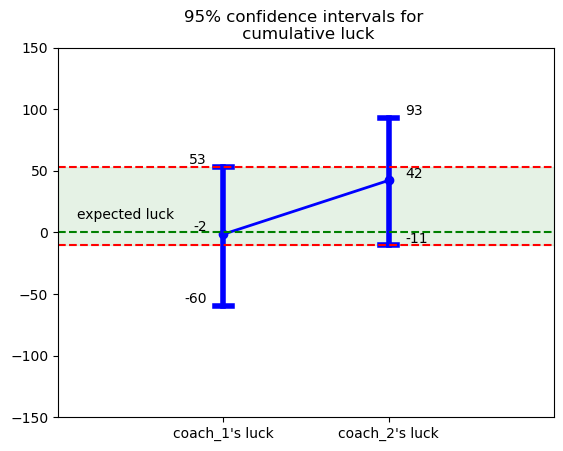

<Figure size 640x480 with 0 Axes>

In [13]:
plt.xlim(0, 3)
plt.ylim(round(min(coach_2_ci_low, coach_1_ci_low), -2)-50, round(max(coach_2_ci_high, coach_1_ci_high), -2)+50)

plt.plot([1, 1], [coach_1_ci_low, coach_1_ci_high], color='b', linewidth=4)
plt.plot([2, 2], [coach_2_ci_low, coach_2_ci_high], color='b', linewidth=4)
plt.plot([1, 2], [coach_1_CL , coach_2_CL ], color='b',  marker='o', linewidth=2)
plt.plot([1-0.05, 1+0.05], [coach_1_ci_high, coach_1_ci_high], color='b', linewidth=4)
plt.plot([1-0.05, 1+0.05], [coach_1_ci_low, coach_1_ci_low], color='b', linewidth=4)
plt.plot([2-0.05, 2+0.05], [coach_2_ci_low, coach_2_ci_low], color='b', linewidth=4)
plt.plot([2-0.05, 2+0.05], [coach_2_ci_high, coach_2_ci_high], color='b', linewidth=4)

plt.text(1-0.1, coach_1_ci_low, f'{coach_1_ci_low:.0f}', ha='right', va='bottom')
plt.text(1-0.1, coach_1_ci_high, f'{coach_1_ci_high:.0f}', ha='right', va='bottom')
plt.text(2+0.1, coach_2_ci_low,  f'{coach_2_ci_low:.0f}', ha='left', va='bottom')
plt.text(2+0.1, coach_2_ci_high,  f'{coach_2_ci_high:.0f}', ha='left', va='bottom')
plt.text(2+0.1, coach_2_CL,  f'{coach_2_CL:.0f}', ha='left', va='bottom')
plt.text(1-0.1, coach_1_CL,  f'{coach_1_CL:.0f}', ha='right', va='bottom')
plt.text(0.7, 20, 'expected luck', ha='right', va='top')

plt.axhline(y=top_margin, color='r', linestyle='--')
plt.axhline(y=low_margin, color='r', linestyle='--')

if top_margin > low_margin:
    plt.fill_betweenx(y=[top_margin, low_margin], x1=0, x2=5, color='green', alpha=0.1)
else:
    plt.fill_betweenx(y=[top_margin, low_margin], x1=0, x2=5, color='red', alpha=0.1)
    
plt.axhline(y=0, color='g', linestyle='--')

plt.xticks([1, 2], [f"{coach_1}'s luck", f"{coach_2}'s luck"])
plt.title("95% confidence intervals for \n cumulative luck")

#plt.savefig('95_ci_CL.jpeg') # раскомментируйте строку, если хотите сохранить картинку
plt.show()
sns.despine()

In [14]:
average_margin = ((top_margin - low_CL) + (top_CL - low_margin)) / 2
overlap = (top_margin - low_margin) / average_margin

С помощью рекомендаций из [статьи](https://www.researchgate.net/publication/7994369_Inference_by_Eye_Confidence_Intervals_and_How_to_Read_Pictures_of_Data) оценим p-value, измеряя степень пересечения наших доверительных интервалов. Цитирую: "Rule of Eye 4: For a comparison of two independent means, p <.05 when the overlap of the 95% CIs is no more than about half the average margin of error, that is, when proportion overlap is about .50 or less." Другими словами, CL тренеров будут статистически значимо различаться, если их 95%-ные доверительные интервалы пересекаются не более чем на 0.5 от средней погрешности.   

In [15]:
if overlap > 0.5:
    print(f"95% CI overlap is {overlap:.2f}, more than 0.5;\nassume p-value > 0.05 and no significant difference between coaches' CL.")
else:
    print(f"95% CI overlap is{overlap:.2f}, less than 0.5;\nassume p-value <= 0.05 and significant difference between coaches' CL.")

95% CI overlap is 1.19, more than 0.5;
assume p-value > 0.05 and no significant difference between coaches' CL.


Как мы видим, в этом случае 95%-ные доверительные интервалы для суммарной удачи обоих тренеров значительно пересекаются, и оба ДИ включают в себя ожидаемое значение CL (0). В данном случае мы не можем сказать, что один тренер был удачливее другого или удачливее теоретически ожидаемого. 